<a href="https://colab.research.google.com/github/danielemarcotulli/MSstats/blob/master/PsychiatricMC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title  { run: "auto", vertical-output: true }
%%capture

from google.colab import files
from google.colab import drive
from google.colab import auth
auth.authenticate_user()
import gspread
from oauth2client.client import GoogleCredentials

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
from datetime import datetime
import scipy.stats as sc
from sklearn.preprocessing import OneHotEncoder
from scipy.stats import ttest_ind
from scipy.stats import kstest
from scipy.stats import mannwhitneyu
from scipy import stats #scegliere una forma delle due per chiamare scipy stats

class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_colwidth', -1)

Go to the following link in your browser:

    https://accounts.google.com/o/oauth2/auth?client_id=32555940559.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=openid+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fuserinfo.email+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcloud-platform+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fappengine.admin+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fcompute+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Faccounts.reauth+https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive&code_challenge=C6WfxHyQAvwm2gJagCiCNLoHYZOYFpibabm7QtrqjFM&code_challenge_method=S256&access_type=offline&response_type=code&prompt=select_account


Enter verification code: ··········


In [ ]:
#importo orca, necessario per scaricare figure create con plotly express
#@title  { run: "auto", vertical-output: true }
%%capture
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [ ]:
#import per rpy2
#@title  { run: "auto", vertical-output: true }
%%capture
%load_ext rpy2.ipython
from rpy2.robjects import r, pandas2ri
import rpy2.rinterface
pandas2ri.activate()
import warnings
from rpy2.rinterface import RRuntimeWarning
warnings.filterwarnings("ignore", category=RRuntimeWarning)
import rpy2.robjects as ro
from rpy2.robjects.packages import importr
from rpy2.robjects import pandas2ri
from rpy2.robjects.conversion import localconverter

def printf(format, *args):
    sys.stdout.write(format % args)

In [ ]:
#@title  { run: "auto", vertical-output: true }
#importo le librerie di R che userò
%%capture
%%R
install.packages('tscount')
library(tscount)
install.packages('MASS')
library(MASS)
install.packages('dplyr')
library(dplyr)
install.packages('glarma')
library(glarma)
install.packages('DescTools')
library(DescTools)

In [ ]:
#definisco qualche funzione che utilizzo poi per i plot e per creare i dizionari con le categorie raggruppate
def group_in_dict(dict_from, column_name, freq, new_dict_name):
  for key, value in dict_from.items():
    value['DATE']=pd.to_datetime(value.DATE,  format='%d/%m/%Y')  
    new_dict_name[key] = value.loc[value[column_name].index].groupby(pd.Grouper(key='DATE',freq=freq)).sum()
    new_dict_name[key] = new_dict_name[key].loc[:, [column_name]]

def plot_trend_curve(curva1, curva2, color1, color2):
  plt.figure(figsize=(12,5))
  ax1 = curva1.plot(color=color1)
  ax2 = ax1.twiny()
  ax2 = curva2.plot(color=color2)
  h1, l1 = ax1.get_legend_handles_labels()
  h2, l2 = ax2.get_legend_handles_labels()
  plt.legend(h1+h2, loc=2)
  plt.savefig('trend_graph.svg')
  files.download('trend_graph.svg')
  plt.show()

def plot_bar(sum_a):
  sum_ap = (sum_a/sum_a.sum())*100
  fig = px.bar(sum_ap, x=sum_ap, y=sum_ap.index, color=sum_ap.index, orientation='h', labels = {'y': 'Referral reason', 'x': 'percentage'})
  fig.update_layout(yaxis={'categoryorder':'total ascending'})
  fig.show()
  fig.write_image("categ_bars.svg")
  files.download('categ_bars.svg')

In [ ]:
gc = gspread.authorize(GoogleCredentials.get_application_default())

In [ ]:
#importo il database dei casi NPI 2019 a Torino e creo un database con i soli casi psichiatrici
%%capture
Tor19 = pd.DataFrame()
Tor19p = pd.DataFrame()
worksheet = gc.open('Database_2019_2020_Torino').worksheet("2019")
rows = worksheet.get_all_values()
Tor19 = pd.DataFrame.from_records(rows)
Tor19.columns= ['ACCESS', 'PATIENT_ID', 'DATE', 'PSY_NEURO', 'EPISODE', 'PREV_THER', 'STOP_THER', 'PREV_DIAG', 'PREV_NPI', 'GENDER', 'SOCIOECON', 'OUTCOME', 'BIRTHDAY']
Tor19 = Tor19.drop(0)
Tor19 = Tor19.reset_index()
Tor19 = Tor19.replace(r'^\s*$', '1/1/2009', regex=True)
Tor19 = Tor19.dropna(subset=['BIRTHDAY'])
Tor19['diff_dates'] = pd.to_datetime(Tor19.DATE,  format='%d/%m/%Y') - pd.to_datetime(Tor19.BIRTHDAY,  format='%d/%m/%Y')
Tor19['AGE']=Tor19['diff_dates']/np.timedelta64(1,'Y')
Tor19 = Tor19.drop(Tor19[(Tor19['PSY_NEURO'] == '2') & (Tor19['AGE'] > 14)].index)
Tor19 = Tor19.reset_index()
Tor19 = Tor19.iloc[0:261]
Tor19p = Tor19.loc[Tor19[(Tor19['PSY_NEURO'] == '1')].index]
Tor19p = Tor19p.reset_index(drop=True)

In [ ]:
#importo il database dei casi NPI 2020 a Torino e creo un database con i soli casi psichiatrici
%%capture
Tor20 = pd.DataFrame()
Tor20p = pd.DataFrame()
worksheet = gc.open('Database_2019_2020_Torino').worksheet("2020")
rows = worksheet.get_all_values()
Tor20 = pd.DataFrame.from_records(rows)
Tor20.columns= ['ACCESS', 'PATIENT_ID', 'DATE', 'PSY_NEURO', 'EPISODE', 'PREV_THER', 'STOP_THER', 'PREV_DIAG', 'PREV_NPI', 'GENDER', 'SOCIOECON', 'OUTCOME', 'BIRTHDAY']
Tor20 = Tor20.loc[1:,:]
Tor20 = Tor20.dropna(subset=['PSY_NEURO'])
Tor20 = Tor20.reset_index()
Tor20 = Tor20.replace(r'^\s*$', '1/1/2009', regex=True)
Tor20 = Tor20.dropna(subset=['BIRTHDAY'])
Tor20['diff_dates'] = pd.to_datetime(Tor20.DATE,  format='%d/%m/%Y') - pd.to_datetime(Tor20.BIRTHDAY,  format='%d/%m/%Y')
Tor20['AGE']=Tor20['diff_dates']/np.timedelta64(1,'Y')
Tor20p = Tor20.loc[Tor20[(Tor20['PSY_NEURO'] == '1')].index]
Tor20p = Tor20p.reset_index()

In [ ]:
%%capture
Rom19 = pd.DataFrame()
Rom19p = pd.DataFrame()
worksheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1VRyrF0d4dmRVZcjFjyxWTzwtJzRIbJUgFdLzE9mr-6k/edit#gid=981354444').worksheet("2019")
rows = worksheet.get_all_values()
Rom19 = pd.DataFrame.from_records(rows)
Rom19 = Rom19.replace(r'^\s*$', np.nan, regex=True)
Rom19.columns= ['PATIENT_ID',	'NOME E COGNOME',	'DATE',	'PSY_NEURO',	'EPISODE',	'EPISODE_cod',	'PREV_THER',	'STOP_THER',	'PREV_DIAG',	'PREV_DIAG_cod',	'PREV_NPI',	'GENDER',	'SOCIOECON',	'OUTCOME',	'BIRTHDAY']
Rom19 = Rom19.drop(columns=['NOME E COGNOME',  'SOCIOECON' ])
Rom19 = Rom19.dropna(subset=['DATE', 'EPISODE', 'PSY_NEURO'])
Rom19 = Rom19.drop(0)
Rom19 = Rom19.reset_index()
Rom19 = Rom19.replace(r'^\s*$', '1/1/2009', regex=True)
Rom19 = Rom19.replace('29/19/2007', '29/09/2007', regex=True)
Rom19 = Rom19.replace('10/02/2010', '10/02/2019', regex=True)
Rom19['DATE'] = Rom19['DATE'].replace('12/04/2011', '12/04/2019', regex=True)
Rom19 = Rom19.replace('14/19/2003', '14/09/2003', regex=True) 
Rom19['PSY_NEURO'] = Rom19['PSY_NEURO'].replace({'1/2': '1'})
Rom19 = Rom19.dropna(subset=['BIRTHDAY'])
Rom19['diff_dates'] = pd.to_datetime(Rom19.DATE,  format='%d/%m/%Y') - pd.to_datetime(Rom19.BIRTHDAY,  format='%d/%m/%Y')
Rom19['AGE']= Rom19['diff_dates']/np.timedelta64(1,'Y')
Rom19 = Rom19.drop(Rom19[(Rom19['PSY_NEURO'] == '2') & (Rom19['AGE'] > 14)].index)
for i in ['22/04/2019', '23/04/2019', '24/04/2019', '25/04/2019', '26/04/2019', '27/04/2019', '28/04/2019', '29/04/2019', '30/04/2019']:
  Rom19 = Rom19.drop(Rom19[(Rom19['DATE'] == i)].index)
Rom19 = Rom19.reset_index()
Rom19p = Rom19.loc[Rom19[(Rom19['PSY_NEURO'] == '1')].index]
Rom19p = Rom19p.reset_index(drop=True)

In [ ]:
%%capture
Rom20 = pd.DataFrame()
Rom20p = pd.DataFrame()
worksheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1VRyrF0d4dmRVZcjFjyxWTzwtJzRIbJUgFdLzE9mr-6k/edit#gid=0').worksheet("2020")
rows = worksheet.get_all_values()
Rom20 = pd.DataFrame.from_records(rows)
Rom20.columns= ['PATIENT_ID',	'NOME E COGNOME',	'DATE',	'PSY_NEURO',	'EPISODE',	'EPISODE_cod',	'PREV_THER',	'STOP_THER',	'PREV_DIAG',	'PREV_NPI',	'GENDER',	'SOCIOECON',	'OUTCOME',	'BIRTHDAY', 'nan']
Rom20 = Rom20.replace(r'^\s*$', np.nan, regex=True)
Rom20 = Rom20.drop(columns=['NOME E COGNOME', 'nan', 'SOCIOECON' ])
Rom20
Rom20 = Rom20.dropna(subset=['DATE', 'EPISODE', 'PSY_NEURO'])
Rom20 = Rom20.drop(0)
Rom20 = Rom20.reset_index()
Rom20['BIRTHDAY'] = Rom20['BIRTHDAY'].replace(r'^\s*$', np.nan, regex=True)
Rom20['BIRTHDAY'] = Rom20['BIRTHDAY'].replace('16 anni', '1/1/2009', regex=True)
Rom20['DATE'] = Rom20['DATE'].replace('05/01/5020', '05/01/2020', regex=True)
Rom20 = Rom20.replace('09/30/2002', '09/03/2002', regex=True)
Rom20 = Rom20.replace('25/02/2003', '25/02/2020', regex=True)
Rom20['DATE'] = Rom20['DATE'].replace('18/02/2019', '18/02/2020', regex=True)

Rom20 = Rom20.dropna(subset=['BIRTHDAY'])
Rom20['diff_dates'] = pd.to_datetime(Rom20.DATE,  format='%d/%m/%Y') - pd.to_datetime(Rom20.BIRTHDAY,  format='%d/%m/%Y')
Rom20['AGE']=Rom20['diff_dates']/np.timedelta64(1,'Y')
Rom20 = Rom20.drop(Rom20[(Rom20['PSY_NEURO'] == '2') & (Rom20['AGE'] > 14)].index)
Rom20 = Rom20.reset_index()
Rom20p = Rom20.loc[Rom20[(Rom20['PSY_NEURO'] == '1')].index]
Rom20p = Rom20p.reset_index(drop=True)

In [ ]:
dict_df = {}
dict_df = {'Tor20' : Tor20p}        

In [ ]:
enc = OneHotEncoder(handle_unknown='ignore')
dict_cat = {}
for key, value in dict_df.items():
  #value = value.replace({'1/2': '1'})
  value['PSY_NEURO'] = value['PSY_NEURO'].astype(int)
  X = value['PSY_NEURO'].to_frame()
  y = value['DATE'].to_frame()
  cat_pn = enc.fit_transform(X, y)
  cat_pn_df = pd.DataFrame(cat_pn.todense())
  cat_pn_df.columns = ['PSY']
  dict_cat[key] = pd.concat([value, cat_pn_df], axis=1)

In [ ]:
ano = ['anorexia', 'weight loss', 'food intake', 'malnutrition', 'alimentare']
agit = ['agitation', 'aggressive', 'agitaz', 'fuga', 'ADHD']
psy = ['psychosis', 'hallucination', 'psychotic', 'disperceptions', 'depersonalizz', 'delirio', 'pensiero', 'disperce']
mood = ['depression', 'emotional', 'social', 'mood', 'abus','sonno', 'farmaci', 'deflesso']
idea = ['ideation', 'idea', 'intenz']
attempt = ['attempt', 'TS']
NSSI = ['self-harm', 'NSSI', 'cutting', 'autoles', 'foreign', 'self - harm']
anxie = ['anxiety', 'scholar', 'pavor', 'ansia', 'panico', 'ossess']
conv = ['conversion', 'headache', 'psychogenic', 'somat', 'FND', 'pseudocrisi', 'tosse', 'visivi', 'slugghish ideomotor skills, headache', 
        'urinary', 'cephalgia', 'sluggish', 'dyspnea', 'gait disorder', 'amnesia', 'lower limb', 'Sincope', 'Tremori', 'Vertigini', 'visus']
tic = ['tics', 'Tic']

d = {
     'anorexia': ano,
     'conversion_dis':conv,
     'agitation': agit,
     'anxiety': anxie,
     'psychosis': psy,
     'mood_dis': mood,
     'self_harm': NSSI,
     'suicidal_idea': idea,
     'suicidal_attempt':attempt,
     }

d_num = {
    1: ano,
    10:tic,
    2: conv,
    3: agit,
    4: anxie,
    5: psy,
    6: mood,
    7: NSSI,
    8: idea,
    9: attempt
     }

for key, value in dict_df.items():
  value['EPISODE_cat_num'] = 0

for key, value in dict_df.items():
  for k, v in d_num.items():
    pat = '|'.join(v)
    mask = value.EPISODE.str.contains(pat, case=False)
    value.loc[mask.fillna(False), 'EPISODE_cat_num'] = k

In [ ]:
#rimuovo i tic (categoria "10") dai database (di Torino e gli psichiatrici classificati come tic a Roma per uniformità).
for key, value in dict_df.items():
  dict_df[key] =  dict_df[key].drop(dict_df[key][dict_df[key]['EPISODE_cat_num'] == 10].index).reset_index(drop=True)
  dict_df[key] =  dict_df[key].drop(dict_df[key][dict_df[key]['EPISODE_cat_num'] == 0].index).reset_index(drop=True)

In [ ]:
dict_df[key]['EPISODE_cat_num']

0      4
1      8
2      4
3      8
4      7
5      3
6      3
7      4
8      8
9      9
10     6
11     9
12     8
13     4
14     4
15     3
16     4
17     3
18     5
19     4
20     1
21     8
22     4
23     3
24     9
25     9
26     4
27     3
28     1
29     9
30     7
31     2
32     9
33     6
34     8
35     8
36     1
37     2
38     3
39     9
40     3
41     8
42     8
43     3
44     4
45     9
46     3
47     3
48     7
49     9
50     7
51     5
52     1
53     8
54     8
55     9
56     2
57     3
58     1
59     4
60     4
61     9
62     3
63     5
64     1
65     3
66     6
67     7
68     8
69     8
70     3
71     4
72     7
73     9
74     3
75     6
76     6
77     8
78     1
79     7
80     7
81     7
82     7
83     2
84     8
85     9
86     6
87     3
88     3
89     5
90     3
91     5
92     1
93     9
94     3
95     3
96     9
97     7
98     4
99     7
100    3
101    8
102    3
103    3
104    8
105    3
106    9
107    1
108    1
109    8
110    3
1

In [ ]:
dict_catnum = {}

for key, value in dict_df.items():
  X = value['EPISODE_cat_num'].to_frame()
  y = value['DATE'].to_frame()
  cat_oh = enc.fit_transform(X, y)
  cat_oh_df = pd.DataFrame(cat_oh.todense())
  cat_cols_name = list(d.keys())
  cat_cols_name = cat_cols_name[0:len(cat_oh_df.columns)]
  cat_oh_df.columns = cat_cols_name
  dict_catnum[key] = pd.concat([value, cat_oh_df], axis=1)

In [ ]:
ricovero = ['ricover', 'Ricover', 'Non dimissibile', 'non dimissibile', '0']
dimissione = ['Approfondimento DEA', 'Dimissibile', 'dimissibile', 'dimesso', 'Dimessio', 'dimessio',  'dimessa', 'Dimesso', 'Dimessa', 'Osservazione DEA', 'oculistico', 'no approfondimenti', 'controllo in dh', 'app.to interno', 'Richiesto', '1', '2']

out = {0: dimissione,
       1: ricovero}

for key, value in dict_df.items():
  value['outcome_cat'] = 0
for key, value in dict_df.items():
  for k, v in out.items():
    pat = '|'.join(v)
    mask = value.OUTCOME.str.contains(pat, case=False)
    value.loc[mask.fillna(False), 'outcome_cat'] = k

In [ ]:
%%capture
dict_out = {}
for key, value in dict_df.items():
  value['outcome_cat'] = value['outcome_cat'].astype(int)
  X = value['outcome_cat'].to_frame()
  y = value['DATE'].to_frame()
  cat_pn = enc.fit_transform(X, y)
  cat_pn_df = pd.DataFrame(cat_pn.todense())
  cat_pn_df.columns = ['dimessi', 'ricoverati']
  dict_out[key] = pd.concat([value, cat_pn_df], axis=1)

In [ ]:
psy_date_w = {}
group_in_dict(dict_cat, 'PSY', 'W', psy_date_w)

In [ ]:

acs20w = pd.concat([psy_date_w['Tor20']], axis=1).fillna(0)

acs20w['psytot20'] = acs20w['PSY'].sum(axis=1)

ValueError: ignored

In [ ]:
dict_ano_w = {}
group_in_dict(dict_catnum,  'anorexia', 'W', dict_ano_w)
dict_conv_w = {}
group_in_dict(dict_catnum,  'conversion_dis', 'W', dict_conv_w)
dict_anx_w = {}
group_in_dict(dict_catnum,  'anxiety', 'W', dict_anx_w)
dict_agit_w = {}
group_in_dict(dict_catnum,  'agitation', 'W', dict_agit_w)  
dict_psyc_w = {}
group_in_dict(dict_catnum,  'psychosis', 'W', dict_psyc_w)  
dict_nssi_w = {}
group_in_dict(dict_catnum,  'self_harm', 'W', dict_nssi_w) 
dict_mood_w = {}
group_in_dict(dict_catnum,  'mood_dis', 'W', dict_mood_w) 
dict_idea_w = {}
group_in_dict(dict_catnum,  'suicidal_idea', 'W', dict_idea_w) 
dict_att_w = {}
group_in_dict(dict_catnum,  'suicidal_attempt', 'W', dict_att_w) 

dict_df_categ = {}
for i in dict_df.keys():
  dict_df_categ[i] = pd.concat([dict_ano_w[i], dict_agit_w[i], dict_conv_w[i], dict_anx_w[i], dict_mood_w[i], 
                                dict_nssi_w[i], dict_psyc_w[i], dict_idea_w[i], dict_att_w[i]], axis=1)

In [ ]:

sum20a = dict_df_categ['Tor20'].iloc[0:25,:].sum() 

In [ ]:
dict_dmsw = {}
group_in_dict(dict_out,  'dimessi', 'W', dict_dmsw)
dict_ricw = {}
group_in_dict(dict_out,  'ricoverati', 'W', dict_ricw)

ricdms19 = pd.concat([dict_dmsw['Tor19'], dict_dmsw['Rom19'], dict_ricw['Tor19'], dict_ricw['Rom19']], axis=1)
ricdms20 = pd.concat([dict_dmsw['Tor20'], dict_dmsw['Rom20'], dict_ricw['Tor20'], dict_ricw['Rom20']], axis=1)
ricdms19['rictot'] = ricdms19['ricoverati'].sum(axis=1)
ricdms19['dmstot'] = ricdms19['dimessi'].sum(axis=1)
ricdms20['rictot'] = ricdms20['ricoverati'].sum(axis=1)
ricdms20['dmstot'] = ricdms20['dimessi'].sum(axis=1)
a19 = ricdms19[['rictot', 'dmstot']].iloc[0:8].sum()
b19 = ricdms19[['rictot', 'dmstot']].iloc[8:16].sum()
a20 = ricdms20[['rictot', 'dmstot']].iloc[0:8, :].sum()
b20 = ricdms20[['rictot', 'dmstot']].iloc[8:16, :].sum()

accessi psichiatrici 2019 e 2020


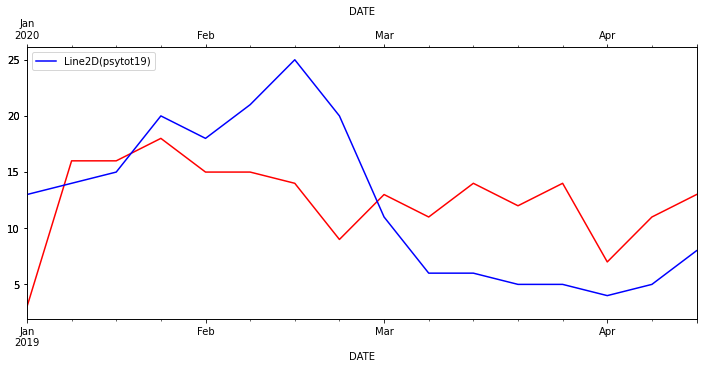

accessi psichiatrici 2020 a Roma e Torino


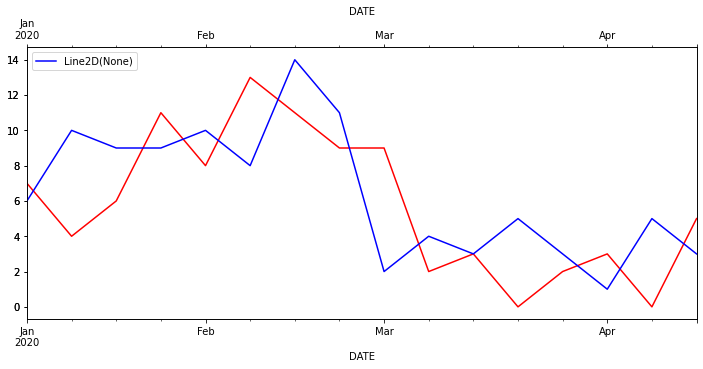

In [ ]:
print(color.BOLD + 'accessi psichiatrici 2019 e 2020')
plot_trend_curve(acs19w.iloc[0:16, :].psytot19, acs20w.iloc[0:16, :].psytot20, 'red', 'blue')
print(color.BOLD + 'accessi psichiatrici 2020 a Roma e Torino')
plot_trend_curve(psy_date_w['Rom20'].iloc[0:16,:].sum(axis=1), psy_date_w['Tor20'].iloc[0:16,:].sum(axis=1), 'red', 'blue')

In [ ]:
#contingency table diagnosi psichiatriche seconda parte 2019 vs seconda parte 2020
diagn1920 = np.array([sum19b, sum20b])

In [ ]:
#chi-quadro con correzione di William's sulla contingency table creata sopra
%%R -i diagn1920
chisq.test(diagn1920)
GTest(diagn1920, correct = c("williams"))

R[write to console]: Error in GTest(diagn1920, correct = c("williams")) : 
  could not find function "GTest"
Calls: <Anonymous> -> <Anonymous> -> withVisible

R[write to console]: In addition: 
R[write to console]: Warning message:

R[write to console]: In chisq.test(diagn1920) :
R[write to console]:  Chi-squared approximation may be incorrect




Error in GTest(diagn1920, correct = c("williams")) : 
  could not find function "GTest"
Calls: <Anonymous> -> <Anonymous> -> withVisible


In [ ]:
#importo orca, necessario per scaricare figure create con plotly express
#@title  { run: "auto", vertical-output: true }
%%capture
!wget https://github.com/plotly/orca/releases/download/v1.2.1/orca-1.2.1-x86_64.AppImage -O /usr/local/bin/orca
!chmod +x /usr/local/bin/orca
!apt-get install xvfb libgtk2.0-0 libgconf-2-4

In [ ]:
print(color.BOLD + 'distribuzione motivi accesso psichiatrici nel 2020 - prima parte \n' + color.END, sum20a)
plot_bar(sum20a)


distribuzione motivi accesso psichiatrici nel 2020 - prima parte 
 anorexia            14.0
agitation           34.0
conversion_dis      4.0 
anxiety             20.0
mood_dis            6.0 
self_harm           14.0
psychosis           5.0 
suicidal_idea       20.0
suicidal_attempt    17.0
dtype: float64


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
Tor19brd = [28, 17]
Rom19brd = [26, 11]
Tor20brd = [13, 13]
Rom20brd = [14, 10]

tor1920rd = np.array([Tor19brd, Tor20brd])
rom1920rd = np.array([Rom19brd, Rom20brd])
chi2_stat, p_val, dof, ex = stats.chi2_contingency(tor1920rd)
print(color.BOLD + "ricoverati vs dimessi a Torino, secondo intervallo 2019 e 2020, Pearson's chi-squared test, p-value:" + color.END, p_val)

chi2_stat, p_val, dof, ex = stats.chi2_contingency(rom1920rd)
print(color.BOLD + "\n ricoverati vs dimessi a Roma, secondo intervallo 2019 e 2020, Pearson's chi-squared test, p-value:" + color.END, p_val)

outcome2nd = np.array([b19, b20])
chi2_stat, p_val, dof, ex = stats.chi2_contingency(outcome2nd)
print(color.BOLD + "\n ricoverati vs dimessi, secondo intervallo 2019 e 2020, Pearson's chi-squared test, p-value:" + color.END, p_val)

ricoverati vs dimessi a Torino, secondo intervallo 2019 e 2020, Pearson's chi-squared test, p-value: 0.45020183292122795

 ricoverati vs dimessi a Roma, secondo intervallo 2019 e 2020, Pearson's chi-squared test, p-value: 0.4947608207335976

 ricoverati vs dimessi, secondo intervallo 2019 e 2020, Pearson's chi-squared test, p-value: 0.7712316050902519


In [ ]:
#maschi femmine chi squared
Tor19bmf = [12,35]
Rom19bmf = [16,26]
Tor20bmf = [11,15]
Rom20bmf = [12,12]

mf19b = [28,61]
mf20b = [23, 27]

mf1920b = np.array([mf19b, mf20b])
Tormf1920b = np.array([Tor19bmf, Tor20bmf])
Rommf1920b = np.array([Rom19bmf, Rom20bmf])
chi2_stat, p_val, dof, ex = stats.chi2_contingency(mf1920b)
print("ricoverati vs dimessi, secondo intervallo 2019 e 2020, Pearson's chi-squared test, p-value:" , p_val)

chi2_stat, p_val, dof, ex = stats.chi2_contingency(Tormf1920b)
print("\n ricoverati vs dimessi, secondo intervallo 2019 e 2020 a Torino, Pearson's chi-squared test, p-value:" , p_val)

chi2_stat, p_val, dof, ex = stats.chi2_contingency(Rommf1920b)
print("\n ricoverati vs dimessi, secondo intervallo 2019 e 2020 a Roma, Pearson's chi-squared test, p-value:" , p_val)

ricoverati vs dimessi, secondo intervallo 2019 e 2020, Pearson's chi-squared test, p-value: 0.12762445213694557

 ricoverati vs dimessi, secondo intervallo 2019 e 2020 a Torino, Pearson's chi-squared test, p-value: 0.22457894926052963

 ricoverati vs dimessi, secondo intervallo 2019 e 2020 a Roma, Pearson's chi-squared test, p-value: 0.49493527502445056


In [ ]:
for key, value in dict_df.items():
  value['DATE']= pd.to_datetime(value.DATE,  format='%d/%m/%Y') 
  for i in ['GENDER']:
    m = dict_df[key].loc[dict_df[key][dict_df[key]['GENDER'] == '1'].index]
    a = pd.DataFrame(m.groupby(pd.Grouper(key='DATE',freq='W'))['GENDER'].count())
    b = a.iloc[0:8,:]
    print(b)
    c=  a.iloc[8:16,:]
    print(c)
    print(key, 'Maschi -primo intervalo:', b.sum().values)
    print(key, 'Maschi - secondo intervalo:', c.sum().values)
    f = dict_df[key].loc[dict_df[key][dict_df[key]['GENDER'] == '2'].index]
    a = pd.DataFrame(f.groupby(pd.Grouper(key='DATE',freq='W'))['GENDER'].count())
    b = a.iloc[0:8,:]
    c=  a.iloc[8:16,:]
    print(key, 'Femmine -primo intervalo:', b.sum().values)
    print(key, 'Femmine - secondo intervalo:', c.sum().values)

            GENDER
DATE              
2019-01-06  1     
2019-01-13  3     
2019-01-20  4     
2019-01-27  5     
2019-02-03  0     
2019-02-10  2     
2019-02-17  2     
2019-02-24  2     
            GENDER
DATE              
2019-03-03  0     
2019-03-10  1     
2019-03-17  3     
2019-03-24  1     
2019-03-31  1     
2019-04-07  2     
2019-04-14  2     
2019-04-21  2     
Tor19 Maschi -primo intervalo: [19]
Tor19 Maschi - secondo intervalo: [12]
Tor19 Femmine -primo intervalo: [36]
Tor19 Femmine - secondo intervalo: [35]
            GENDER
DATE              
2019-01-13  4     
2019-01-20  3     
2019-01-27  0     
2019-02-03  6     
2019-02-10  4     
2019-02-17  3     
2019-02-24  1     
2019-03-03  4     
            GENDER
DATE              
2019-03-10  4     
2019-03-17  2     
2019-03-24  0     
2019-03-31  3     
2019-04-07  1     
2019-04-14  0     
2019-04-21  6     
Rom19 Maschi -primo intervalo: [25]
Rom19 Maschi - secondo intervalo: [16]
Rom19 Femmine -primo intervalo: 

In [ ]:
for key, value in dict_out.items():
  value['DATE']= pd.to_datetime(value.DATE,  format='%d/%m/%Y') 
  for i in ['outcome_cat']:
    d = dict_out[key].loc[dict_out[key][dict_out[key]['dimessi'] == 1].index]
    a = pd.DataFrame(d.groupby(pd.Grouper(key='DATE',freq='W'))['PATIENT_ID'].count())
    b = a.iloc[0:8,:]
    c=  a.iloc[8:16,:]
    print(key, 'dimessi -primo intervalo:', b.sum().values)
    print(key, 'dimessi - secondo intervalo:', c.sum().values)
    r = dict_out[key].loc[dict_out[key][dict_out[key]['ricoverati'] == 1].index]
    a = pd.DataFrame(r.groupby(pd.Grouper(key='DATE',freq='W'))['PATIENT_ID'].count())
    b = a.iloc[0:8,:]
    c=  a.iloc[8:16,:]
    print(key, 'ricoverati -primo intervalo:', b.sum().values)
    print(key, 'ricoverati - secondo intervalo:', c.sum().values)

Tor19 dimessi -primo intervalo: [33]
Tor19 dimessi - secondo intervalo: [28]
Tor19 ricoverati -primo intervalo: [24]
Tor19 ricoverati - secondo intervalo: [17]
Rom19 dimessi -primo intervalo: [29]
Rom19 dimessi - secondo intervalo: [26]
Rom19 ricoverati -primo intervalo: [29]
Rom19 ricoverati - secondo intervalo: [11]
Tor20 dimessi -primo intervalo: [40]
Tor20 dimessi - secondo intervalo: [13]
Tor20 ricoverati -primo intervalo: [35]
Tor20 ricoverati - secondo intervalo: [13]
Rom20 dimessi -primo intervalo: [51]
Rom20 dimessi - secondo intervalo: [14]
Rom20 ricoverati -primo intervalo: [18]
Rom20 ricoverati - secondo intervalo: [10]


In [ ]:
for key, value in dict_df.items():
  value['DATE']= pd.to_datetime(value.DATE,  format='%d/%m/%Y') 
  df = value
  for i in ['PATIENT_ID']:
    m = dict_df[key].loc[dict_df[key][(dict_df[key]['PREV_NPI'] == '0') & (dict_df[key]['PREV_DIAG'] == '0')].index]
    a = pd.DataFrame(m.groupby(pd.Grouper(key='DATE',freq='W'))['PATIENT_ID'].count())
    b = a.iloc[0:8,:]
    c=  a.iloc[8:16,:]
    print(key, 'pazienti senza precedenti -primo intervalo:', b.sum().values)
    print(key, 'pazienti senza precedenti - secondo intervalo:', c.sum().values)

Tor19 pazienti senza precedenti -primo intervalo: [18]
Tor19 pazienti senza precedenti - secondo intervalo: [16]
Rom19 pazienti senza precedenti -primo intervalo: [9]
Rom19 pazienti senza precedenti - secondo intervalo: [9]
Tor20 pazienti senza precedenti -primo intervalo: [28]
Tor20 pazienti senza precedenti - secondo intervalo: [7]
Rom20 pazienti senza precedenti -primo intervalo: [20]
Rom20 pazienti senza precedenti - secondo intervalo: [2]


Kolgorov-Smirnov test against normal distribution: KstestResult(statistic=0.9999292955063416, pvalue=0.0)

Kolgorov-Smirnov test against normal distribution: KstestResult(statistic=0.9994860019728155, pvalue=3.7722392754616295e-293)

 
Mann-Whitney 2nd interval 2019 vs 2nd interval 2020: MannwhitneyuResult(statistic=6611.0, pvalue=0.023464343231086666)

Mann-Whitney 2nd interval vs 1st interval 2020: MannwhitneyuResult(statistic=10855.0, pvalue=0.029120224763543447)


2nd (upper graph) and 1st (below) interval, Age distribution 2019 vs 2020


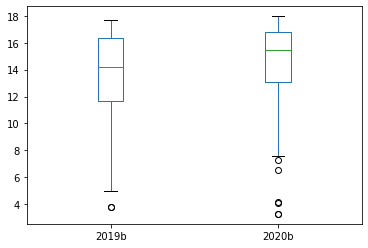

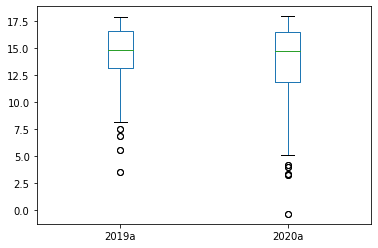

In [ ]:
Age19 = pd.concat([dict_df['Tor19'], dict_df['Rom19']])
Age20 = pd.concat([dict_df['Tor20'], dict_df['Rom20']])
Age19['DATE1'] = pd.to_datetime(Age19.DATE,  format='%d/%m/%Y') 
Age20['DATE1'] = pd.to_datetime(Age20.DATE,  format='%d/%m/%Y') 

#normality check
print(color.BOLD + 'Kolgorov-Smirnov test against normal distribution:' + color.END, kstest(Age19['AGE'].loc[Age19[Age19['DATE1'] > '2019-02-24'].index], 'norm'))
print(color.BOLD + '\nKolgorov-Smirnov test against normal distribution:' + color.END, kstest(Age20['AGE'].loc[Age20[Age20['DATE1'] > '2020-02-24'].index], 'norm'))

Age2nd = pd.concat([Age19['AGE'].loc[Age19[Age19['DATE1'] > '2019-02-24'].index].reset_index(), Age20['AGE'].loc[Age20[Age20['DATE1'] > '2020-02-24'].index].reset_index()], axis=1)
Age1st = pd.concat([Age19['AGE'].loc[Age19[Age19['DATE1'] < '2019-02-24'].index].reset_index(), Age20['AGE'].loc[Age20[Age20['DATE1'] < '2020-02-24'].index].reset_index()], axis=1)

print(color.BOLD + '\n \nMann-Whitney 2nd interval 2019 vs 2nd interval 2020:' + color.END, 
      mannwhitneyu(Age19['AGE'].loc[Age19[Age19['DATE1'] > '2019-02-24'].index], Age20['AGE'].loc[Age20[Age20['DATE1'] > '2020-02-24'].index], alternative='two-sided'))
print(color.BOLD + '\nMann-Whitney 2nd interval vs 1st interval 2020:' + color.END, 
      mannwhitneyu(Age20['AGE'].loc[Age20[Age20['DATE1'] < '2020-02-24'].index], Age20['AGE'].loc[Age20[Age20['DATE1'] > '2020-02-24'].index], alternative='two-sided'))

Age2nd = Age2nd.drop(columns='index')
Age2nd.columns =['2019b', '2020b']
Age1st = Age1st.drop(columns='index')
Age1st.columns =['2019a', '2020a']

print(color.BOLD + '\n\n2nd (upper graph) and 1st (below) interval, Age distribution 2019 vs 2020' + color.END)
Age2nd.plot.box()
Age1st.plot.box()

In [ ]:
dict_df['Rom19']['DATE1'] = pd.to_datetime(dict_df['Rom19'].DATE,  format='%d/%m/%Y') 
dict_df['Rom20']['DATE1'] = pd.to_datetime(dict_df['Rom20'].DATE,  format='%d/%m/%Y')
dict_df['Tor19']['DATE1'] = pd.to_datetime(dict_df['Tor19'].DATE,  format='%d/%m/%Y') 
dict_df['Tor20']['DATE1'] = pd.to_datetime(dict_df['Tor20'].DATE,  format='%d/%m/%Y')
print(mannwhitneyu(dict_df['Rom19']['AGE'].loc[dict_df['Rom19'][dict_df['Rom19']['DATE1'] > '2019-02-24'].index], dict_df['Rom20']['AGE'].loc[dict_df['Rom20'][dict_df['Rom20']['DATE1'] > '2020-02-24'].index], alternative='two-sided'))
print(mannwhitneyu(dict_df['Tor19']['AGE'].loc[dict_df['Tor19'][dict_df['Tor19']['DATE1'] > '2019-02-24'].index], dict_df['Tor20']['AGE'].loc[dict_df['Tor20'][dict_df['Tor20']['DATE1'] > '2020-02-24'].index], alternative='two-sided'))

MannwhitneyuResult(statistic=484.0, pvalue=0.5710903962280459)
MannwhitneyuResult(statistic=431.5, pvalue=0.039203111903899614)


In [ ]:
print('2019 1st - median:', Age19['AGE'].loc[Age19[Age19['DATE1'] < '2019-02-24'].index].median())
print('2019 1st - iqr_25:', Age19['AGE'].loc[Age19[Age19['DATE1'] < '2019-02-24'].index].quantile(q=0.25))
print('2019 1st - iqr_75:', Age19['AGE'].loc[Age19[Age19['DATE1'] < '2019-02-24'].index].quantile(q=0.75))
print('2019 2nd - median:', Age19['AGE'].loc[Age19[Age19['DATE1'] > '2019-02-23'].index].median())
print('2019 2nd - iqr_25:', Age19['AGE'].loc[Age19[Age19['DATE1'] > '2019-02-23'].index].quantile(q=0.25))
print('2019 2nd - iqr_75:', Age19['AGE'].loc[Age19[Age19['DATE1'] > '2019-02-23'].index].quantile(q=0.75))

print('2020 1st - median:', Age20['AGE'].loc[Age20[Age20['DATE1'] < '2020-02-24'].index].median())
print('2020 1st - iqr_25:', Age20['AGE'].loc[Age20[Age20['DATE1'] < '2020-02-24'].index].quantile(q=0.25))
print('2020 1st - iqr_75:', Age20['AGE'].loc[Age20[Age20['DATE1'] < '2020-02-24'].index].quantile(q=0.75))
print('2020 2nd - median:', Age20['AGE'].loc[Age20[Age20['DATE1'] > '2020-02-23'].index].median())
print('2020 2nd - iqr_25:', Age20['AGE'].loc[Age20[Age20['DATE1'] > '2020-02-23'].index].quantile(q=0.25))
print('2020 2nd - iqr_75:', Age20['AGE'].loc[Age20[Age20['DATE1'] > '2020-02-23'].index].quantile(q=0.75))

2019 1st - median: 14.831242256856747
2019 1st - iqr_25: 13.12894857526164
2019 1st - iqr_75: 16.605405997385297
2019 2nd - median: 14.196047831235411
2019 2nd - iqr_25: 11.652532221743089
2019 2nd - iqr_75: 16.200195760351
2020 1st - median: 14.738153418619138
2020 1st - iqr_25: 11.879778503323134
2020 1st - iqr_75: 16.471248554042862
2020 2nd - median: 15.480126217513023
2020 2nd - iqr_25: 13.122788284495916
2020 2nd - iqr_75: 16.742301347734724


In [ ]:
worksheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1ZCQ_s9clRqd3enlnjDtTnXn5GioDClcP2ZzObKmelvE/edit').sheet1
rows = worksheet.get_all_values()
EDTor20 = pd.DataFrame.from_records(rows)
EDTor20 = EDTor20.replace(r'^\s*$', np.nan, regex=True)
EDTor20 = EDTor20.reset_index()
EDTor20s = EDTor20.loc[:, [0, 1, 20]]
EDTor20sel = EDTor20s.loc[EDTor20s[1] == 'Totale']
EDTor20sel.columns = ['DATE', 'codice', 'Tot']
EDTor20sel = EDTor20sel.reset_index()
EDTor20sel['Tot'] =  EDTor20sel['Tot'].str.replace('.', '')
EDTor20sel['Tot'] = EDTor20sel['Tot'].astype(int)

In [ ]:
worksheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/12M0pAnThiyQPBf8ENqC0J8feCvnOoX94DJ1HmKWwOVA/edit?usp=drive_web&ouid=102191434378304040369').sheet1
rows = worksheet.get_all_values()
EDTor19 = pd.DataFrame.from_records(rows)
EDTor19 = EDTor19.replace(r'^\s*$', np.nan, regex=True)
EDTor19 = EDTor19.reset_index()
EDTor19s = EDTor19.loc[:, [0, 1, 22]]
EDTor19sel = EDTor19s.loc[EDTor19s[1] == 'Totale']
EDTor19sel.columns = ['DATE', 'codice', 'Tot']
EDTor19sel = EDTor19sel.reset_index()
EDTor19sel['Tot'] =  EDTor19sel['Tot'].str.replace('.', '')
EDTor19sel['Tot'] = EDTor19sel['Tot'].astype(int)

In [ ]:
worksheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1FiiiQkhDLlhWlD8WTZLiQ3qV4gQp_8hsLFRREo0TWXU/edit#gid=567110158').worksheet("2020")
rows = worksheet.get_all_values()
EDRom20 = pd.DataFrame.from_records(rows)
EDRom20 = EDRom20.reset_index()
EDRom20 = EDRom20.drop(0, 1)
EDRom20.columns = EDRom20.iloc[1]
EDRom20.columns = [1, 'settimana', 'triage', 'Pronto Soccorso', 'Centrale', 'Pediatrico', '< 18 Anni']
EDRom20 = EDRom20.replace(r'^\s*$', np.nan, regex=True)
EDRom20sel = EDRom20.loc[EDRom20['triage'].isna()]
EDRom20selacc = EDRom20sel.loc[14:119, 'Pediatrico']
RomDEA20 = EDRom20selacc.astype(int).reset_index(drop=True)

In [ ]:
worksheet = gc.open_by_url('https://docs.google.com/spreadsheets/d/1FiiiQkhDLlhWlD8WTZLiQ3qV4gQp_8hsLFRREo0TWXU/edit#gid=567110158').worksheet("2019")
rows = worksheet.get_all_values()
EDRom19 = pd.DataFrame.from_records(rows)
EDRom19 = EDRom19.reset_index()
EDRom19 = EDRom19.drop(0, 1)
EDRom19.columns = EDRom19.iloc[1]
EDRom19.columns = [1, 'settimana', 'triage', 'Pronto Soccorso', 'Centrale', 'Pediatrico', '< 18 Anni']
EDRom19 = EDRom19.replace(r'^\s*$', np.nan, regex=True)
EDRom19sel = EDRom19.loc[EDRom19['triage'].isna()]
EDRom19selacc = EDRom19sel.loc[12:95, 'Pediatrico']
RomDEA19 = EDRom19selacc.astype(int).reset_index(drop=True)

In [ ]:
DEA20 = EDTor20sel['Tot'] + RomDEA20
DEA19 = EDTor19sel['Tot'] + RomDEA19

In [ ]:
acs19wi = acs19w
acs20wi = acs20w
acs20wi['DATE'] = acs20wi.index
acs20wi['DATE'] = acs20wi['DATE'].dt.strftime('%m-%d')
acs19wi['DATE'] = acs19wi.index
acs19wi['DATE'] = acs19wi['DATE'].dt.strftime('%m-%d')
acs19wi = acs19wi.set_index('DATE')
acs20wi = acs20wi.set_index('DATE')
acs1920w = pd.concat([acs19wi, acs20wi], axis=1)
acs1920w = acs1920w.fillna(0)
npi20w = acs1920w['psytot20'].iloc[16:32].reset_index(drop=True)
npi19w = acs1920w['psytot19'].iloc[0:16].reset_index(drop=True)
tor_npi19w = acs1920w.iloc[0:16, 1]
rom_npi19w = acs1920w.iloc[0:16, 2]
tor_npi20w = acs1920w.iloc[16:32, 3]
rom_npi20w = acs1920w.iloc[16:32, 4]

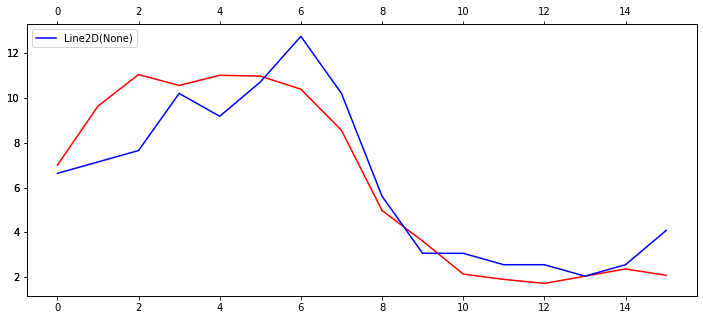

In [ ]:
npi20w_perc = (npi20w/npi20w.sum())*100
DEA20_perc = (DEA20/DEA20.sum())*100
plot_trend_curve(DEA20_perc, npi20w_perc, 'red', 'blue')

In [ ]:
%%R -i tor_npi20w,rom_npi20w
npi20rt <- append(tor_npi20w, rom_npi20w)
covid0w <- rep(0, 8)
covid1w <- rep(1, 8)
covidw <- append(covid0w, covid1w)
covidw2 <- append(covidw, covidw)
covidw2 <- as.factor(covidw2)
sitetor <- rep(1, 16)
siterom <- rep(2, 16)
site <- append(sitetor, siterom)
site <- as.factor(site)
rt20glm <- glm(npi20rt ~ covidw2 + site, family=poisson(link=log))
summary(rt20glm)


Call:
glm(formula = npi20rt ~ covidw2 + site, family = poisson(link = log))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.4354  -0.5962  -0.1593   0.5242   2.8132  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   2.2608     0.1070  21.122  < 2e-16 ***
covidw21     -1.0716     0.1639  -6.540 6.16e-11 ***
site2        -0.1021     0.1430  -0.714    0.475    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 87.222  on 31  degrees of freedom
Residual deviance: 37.603  on 29  degrees of freedom
AIC: 150.56

Number of Fisher Scoring iterations: 5



In [ ]:
%%R -i tor_npi19w,rom_npi19w
npi19rt <- append(tor_npi19w, rom_npi19w)
covid0w <- rep(0, 8)
covid1w <- rep(1, 8)
covidw <- append(covid0w, covid1w)
covidw2 <- append(covidw, covidw)
covidw2 <- as.factor(covidw2)
sitetor <- rep(1, 16)
siterom <- rep(2, 16)
site <- append(sitetor, siterom)
site <- as.factor(site)
rt19glm <- glm(npi19rt ~ covidw2 + site, family=poisson(link=log))
summary(rt19glm)


Call:
glm(formula = npi19rt ~ covidw2 + site, family = poisson(link = log))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.3920  -0.3584   0.3059   0.6486   1.2748  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   1.8410     0.1160  15.869  < 2e-16 ***
covidw21     -0.1011     0.1162  -0.870    0.384    
site2         0.7390     0.1241   5.956 2.58e-09 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 73.996  on 31  degrees of freedom
Residual deviance: 35.302  on 29  degrees of freedom
AIC: 167.27

Number of Fisher Scoring iterations: 4



In [ ]:
%%R -i tor_npi19w,rom_npi19w,tor_npi20w,rom_npi20w
npi20rt <- append(tor_npi20w[9:16], rom_npi20w[9:16])
npi19rt <- append(tor_npi19w[9:16], rom_npi19w[9:16])
npi1920rt <- append(npi19rt, npi20rt)
print(length(npi1920rt))
covid0w <- rep(0, 16)
covid1w <- rep(1, 16)
covidw <- append(covid0w, covid1w)
#covidw2 <- append(covidw, covidw)
covidw <- as.factor(covidw)
print(length(covidw))
sitetor <- rep(1, 8)
siterom <- rep(2, 8)
sitert <-append(sitetor, siterom)
site <- append(sitert, sitert)
sitert <- as.factor(sitert)
rt19glm <- glm(npi1920rt ~ covidw + site, family=poisson(link=log))
summary(rt19glm)

[1] 32
[1] 32

Call:
glm(formula = npi1920rt ~ covidw + site, family = poisson(link = log))

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-2.7907  -1.0142   0.1369   0.5919   2.2064  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)   1.3913     0.2565   5.423 5.86e-08 ***
covidw1      -1.0367     0.1646  -6.299 3.00e-10 ***
site          0.5025     0.1493   3.365 0.000765 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 98.969  on 31  degrees of freedom
Residual deviance: 42.118  on 29  degrees of freedom
AIC: 153.47

Number of Fisher Scoring iterations: 5



In [ ]:
#modello con offset
%%R -i npi20w,DEA20
covid0w <- rep(0, 8)
covid1w <- rep(1, 8)
covidw <- append(covid0w, covid1w)
# mod19go <- glarma(npi19w, offset=log(DEA19),  residuals = "Pearson", X = cbind(intercept=rep(1, length(npi19w)), covidw), thetaLags=1, type = "Poi") #, offset=log(DEA20
# summary(mod19go)

mod20go <- glarma(npi20w, offset=log(DEA20),  residuals = "Pearson", X = cbind(intercept=rep(1, length(npi20w)), covidw), thetaLags=1, type = "Poi") #, offset=log(DEA20
summary(mod20go)


Call: glarma(y = npi20w, X = cbind(intercept = rep(1, length(npi20w)), 
    covidw), offset = log(DEA20), type = "Poi", residuals = "Pearson", 
    thetaLags = 1)

Pearson Residuals:
     Min        1Q    Median        3Q       Max  
-0.92824  -0.57805  -0.00843   0.55732   1.38739  

GLARMA Coefficients:
        Estimate Std.Error z-ratio Pr(>|z|)  
theta_1  0.14526   0.08752    1.66   0.0969 .

Linear Model Coefficients:
          Estimate Std.Error z-ratio Pr(>|z|)    
intercept  -4.3757    0.1263 -34.637   <2e-16 ***
covidw      0.2559    0.2095   1.221    0.222    

    Null deviance: 11.050  on 15  degrees of freedom
Residual deviance:  7.398  on 13  degrees of freedom
AIC: 80.25972 

Number of Fisher Scoring iterations: 30

LRT and Wald Test:
Alternative hypothesis: model is a GLARMA process
Null hypothesis: model is a GLM with the same regression structure
          Statistic p-value  
LR Test       1.337  0.2475  
Wald Test     2.755  0.0969 .
---
Signif. codes:  0 ‘***’ 0.00

In [ ]:
%%R -i tor_npi20w,rom_npi20w,tor_npi19w,rom_npi19w
tor20g <- glarma(tor_npi20w, residuals = "Pearson", X = cbind(intercept=rep(1, length(tor_npi20w)), covidw),  type = "Poi") #, offset=log(DEA20
summary(tor20g)

rom20g <- glarma(rom_npi20w, residuals = "Pearson", X = cbind(intercept=rep(1, length(rom_npi20w)), covidw),  type = "Poi") #, offset=log(DEA20
summary(rom20g)

In [ ]:
%%R -i npi19w
library(glarma)
covid0w <- rep(0, 8)
covid1w <- rep(1, 8)
covidw <- append(covid0w, covid1w)
mod20g <- glarma(npi20w,  residuals = "Pearson", X = cbind(intercept=rep(1, length(npi20w)), covidw), thetaLags=1,type = "Poi")  #, offset=log(DEA20
mod19g <- glarma(npi19w,  residuals = "Pearson", X = cbind(intercept=rep(1, length(npi19w)), covidw), thetaLags=1, type = "Poi") #
summary(mod19g)

In [ ]:
%%R -i npi19w
print(npi19w)

In [ ]:
#glm Poisson for prediction 8 weeks ahead
%%R -i npi19w,npi20w -o mod20glm,glmpred
covid0w <- rep(0, 8)
covid1w <- rep(1, 7)
covidw <- append(covid0w, covid1w)
mod20glm <- glm(npi20w[0:8] ~ npi19w[0:8], family=poisson(link=log))

glmpred <- predict(mod20glm, newdata = data.frame(cbind(npi19w[9:16])),
            type = c("response"))

In [ ]:
%%capture
%%R
install.packages('ciTools')
library(ciTools)

In [ ]:
%%R -i mod20glm -o pred_obs_20 
# library(plyr)
# bootSimFun <- function(fit,data) {
#     bdat <- data[sample(seq(nrow(data)),size=nrow(data),replace=TRUE),]
#     bfit <- update(fit,data=bdat)
#     bpred <- predict(bfit,type="response", newdata= data.frame(cbind(npi19w[9:16])))
#     rpois(length(bpred),lambda=bpred)
# }
# set.seed(101) 
# simvals <- raply(500,bootSimFun(fit=mod20glm, data= data.frame(cbind(npi20w[0:8], nrow=8))   ))
# CI <- t(apply(simvals,2,quantile,c(0.025,0.975))) 

CIs <- add_pi(data.frame(cbind(npi19w[9:16])), mod20glm)
a <- pull(CIs, LPB0.025)
b <- pull(CIs, UPB0.975)
pred20 <- append(npi20w[0:8], glmpred)
pred20il <- append(npi20w[0:8], a)
pred20iu <- append(npi20w[0:8], b)
settimane <- c(1,2,3,4,5,6,7,8,9,10,11,12,13,14,15, 16)
pred_obs_20 <-cbind(settimane, npi20w, npi19w, pred20, pred20il, pred20iu)
print(pred_obs_20)
# print(CIs)

   settimane npi20w npi19w   pred20 pred20il pred20iu
0          1     13      3 13.00000       13       13
1          2     14     16 14.00000       14       14
2          3     15     16 15.00000       15       15
3          4     20     18 20.00000       20       20
4          5     18     15 18.00000       18       18
5          6     21     15 21.00000       21       21
6          7     25     14 25.00000       25       25
7          8     20      9 20.00000       20       20
8          9     11     13 15.63298        7       27
9         10      6     11 18.96960       11       29
10        11      6     14 18.96960       10       29
11        12      5     12 19.54266       10       31
12        13      5     14 18.68940       10       29
13        14      4      7 18.68940       10       28
14        15      5     11 18.41334       10       28
15        16      8     13 17.09301        9       27


In [ ]:
%%R
exp(-0.97)

In [ ]:
with localconverter(ro.default_converter + pandas2ri.converter):
  pd_pred_obs = ro.conversion.rpy2py(pred_obs_20)

pd_pred_obs20 = pd.DataFrame(data=pd_pred_obs, columns=["Week", "obs", "obs19", "pred", "lower", "upper"])
print(pd_pred_obs20)

    Week   obs  obs19       pred  lower  upper
0   1.0   13.0  3.0    13.000000  13.0   13.0 
1   2.0   14.0  16.0   14.000000  14.0   14.0 
2   3.0   15.0  16.0   15.000000  15.0   15.0 
3   4.0   20.0  18.0   20.000000  20.0   20.0 
4   5.0   18.0  15.0   18.000000  18.0   18.0 
5   6.0   21.0  15.0   21.000000  21.0   21.0 
6   7.0   25.0  14.0   25.000000  25.0   25.0 
7   8.0   20.0  9.0    20.000000  20.0   20.0 
8   9.0   11.0  13.0   15.632982  7.0    27.0 
9   10.0  6.0   11.0   18.969600  11.0   29.0 
10  11.0  6.0   14.0   18.969600  10.0   29.0 
11  12.0  5.0   12.0   19.542664  10.0   31.0 
12  13.0  5.0   14.0   18.689401  10.0   29.0 
13  14.0  4.0   7.0    18.689401  10.0   28.0 
14  15.0  5.0   11.0   18.413340  10.0   28.0 
15  16.0  8.0   13.0   17.093012  9.0    27.0 


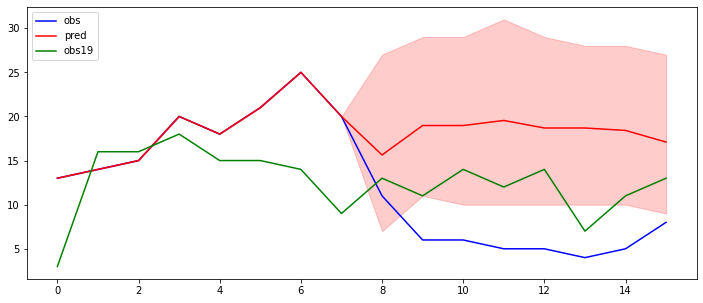

In [ ]:
plt.figure(figsize=(12,5))
ax1 = pd_pred_obs20.obs.plot(color='blue')
#ax2 = ax1.twiny()
ax2 = pd_pred_obs20.pred.plot(color='red')
ax2.fill_between((pd_pred_obs20.Week-1), pd_pred_obs20.lower, pd_pred_obs20.upper, color='red', alpha=0.2)
#ax3 = ax1.twiny()
ax3 = pd_pred_obs20.obs19.plot(color='green')
ax1.set_label('obs')
ax1.set_label('pred')
plt.legend(loc=2)
plt.savefig('obs.svg')
files.download('obs.svg')